In [7]:
using Rocket
using ReactiveMP
using GraphPPL
using Distributions
using Random
using BenchmarkTools

┌ Info: Precompiling ReactiveMP [a194aa59-28ba-4574-a09c-4a745416d6e3]
└ @ Base loading.jl:1278
┌ Warning: Package ReactiveMP does not have Rocket in its dependencies:
│ - If you have ReactiveMP checked out for development and have
│   added Rocket as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with ReactiveMP
└ Loading Rocket into ReactiveMP from project dependency, future warnings for ReactiveMP are suppressed.
┌ Info: Precompiling GraphPPL [b3f8163a-e979-4e85-b43e-1f63d8c8b42c]
└ @ Base loading.jl:1278
┌ Warning: Package GraphPPL does not have ReactiveMP in its dependencies:
│ - If you have GraphPPL checked out for development and have
│   added ReactiveMP as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with GraphPPL
└ Loading ReactiveMP into GraphPPL from project dependency, future 

In [8]:
@model [ outbound_message_portal = EmptyPortal() ] function gaussian_mixture_model(n)
    
    s ~ Beta(1.0, 1.0)
    
    m1 ~ NormalMeanVariance(0.0, 100.0)
    w1 ~ Gamma(0.01, 100.0)
    
    m2 ~ NormalMeanVariance(0.0, 100.0)
    w2 ~ Gamma(0.01, 100.0)
    
    z = randomvar(n)
    y = datavar(Float64, n)
    
    for i in 1:n
        z[i] ~ Bernoulli(s) where { q = MeanField() }
        y[i] ~ NormalMixture(z[i], (m1, m2), (w1, w2)) where { q = MeanField() }
    end
    
    return s, m1, w1, m2, w2, z, y
end

gaussian_mixture_model (generic function with 1 method)

In [9]:
using Random

In [165]:
function inference(data)
    n = length(data)
    model, (s, m1, w1, m2, w2, z, y) = gaussian_mixture_model(n);
    
    buffer = Vector{Marginal}()
    fe = Vector{Float64}()
    
    fe_scheduler = PendingScheduler()
    
    switchsub = subscribe!(getmarginal(s), (ms) -> push!(buffer, ms))
    fesub = subscribe!(score(BetheFreeEnergy(), model, fe_scheduler), (f) -> push!(fe, f))
    
    setmarginal!(s, vague(Beta))
    setmarginal!(m1, NormalMeanVariance(-1.0, 1e4))
    setmarginal!(m2, NormalMeanVariance(2.0, 1e4))
    setmarginal!(w1, vague(Gamma))
    setmarginal!(w2, vague(Gamma))
    
    for i in 1:25
        update!(y, data)
        release!(fe_scheduler)
    end
    
    unsubscribe!(fesub)
    unsubscribe!(switchsub)
    
    return buffer, fe
end

inference (generic function with 1 method)

In [188]:
n = 1500

Random.seed!(124)

switch = 0.23
z      = rand(n) .< switch
y      = Vector{Float64}(undef, n)

d1 = Normal(-2.0, 0.75)
d2 = Normal(+2.0, 0.75)

for i in 1:n
    y[i] = z[i] ? rand(d1) : rand(d2)
end

In [192]:
@time marginals, fe = inference(y);

  3.278661 seconds (11.72 M allocations: 566.679 MiB, 16.56% gc time)


In [190]:
using Plots

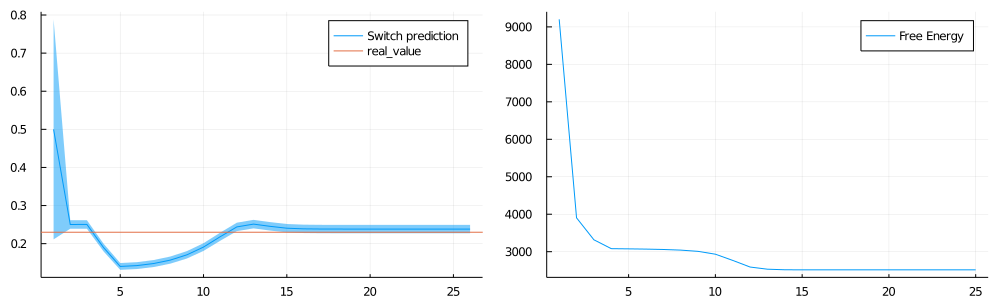

In [191]:
swp = plot(mean.(marginals), ribbon = var.(marginals) .|> sqrt, label = "Switch prediction")
swp = plot!(swp, [ switch ], seriestype = :hline, label = "real_value")

fep = plot(fe, label = "Free Energy")

plot(swp, fep, size = (1000, 300))